# Importamos librerías - Creamos el dataframe de pericias

In [27]:
import pandas as pd
import numpy as np
from pprint import pprint

df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)
len(df)

3806

## Limpieza de texto

In [28]:
# Limpieza de texto
# Primera etapa de la limpieza de texto
import re, string, unicodedata
'''
Se hace la eliminacion de texto entre corchetes, acentos, signos de puntuacion (excepto . y :), palabras con numeros.
Se eliminan los espacios de sobra
Se eliminan \r, \t, \v, \f, \a
'''
def limpiarTexto1(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    '''
    Eliminamos caracteres especiales: tabulador orizontal(\t), tabulador vertical(\v), 
    retorno de carro(\r), avance de pagina(\f), 
    caracter de retroceso: Marca el límite de una palabra(\b), 
    '''
    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt
df1 = df1.apply(str)
df1 = df1.apply(limpiarTexto1)

In [29]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('^ ',' ',text)
    text = re.sub('\n +\n','\n',text)
    text = re.sub(' +\n\n','\n',text)
    text = re.sub('\n\n+','\n',text)
    text = re.sub(' \n','\n',text)
    text = re.sub('\d\n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('\d+-\d+','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('[nN]º|[nN][. ]º','',text)
    text = re.sub('[º<>/]','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('[a-zA-z-.]+@[a-zA-Z]+.com','',text)
    return text

df1 = df1.apply(limpiarTexto2)

In [30]:
# Tercera fase de limpieza
# Eliminamos las lineas que no son de utilidad para el analisis o que van a afectar los resultados del mismo.
# Ejemplo de linea eliminada: las lineas que comienzan con "Se encuentra contestada en....."
import re

def limpiarTexto3(text):
    text = re.sub('[a-z1-9.]+[).-] [s|S]e encuentra contestad[a|o] .+[. \n]','',text)
    text = re.sub('[0-9]+[. ]+[yY]a fue contestado.+[.\n]','',text)
    text = re.sub('[fF]oja [1-9].+\n', '', text)
    text = re.sub('[pP]regunta[ 0-9]+[)].+\n|[rR]espuesta[ 0-9]+[)].+\n','',text)#elimina oraciones comenzadas en preguta/respuesta.
    text = re.sub('V[. ]+[S\n\.]+', '', text)
    #text = re.sub('[IV]+.[A-Z]{1,3}[\n.]', '', text)
    text = re.sub('[I][.][P][.]','',text)
    text = re.sub('[I][.][T][.]','',text)
    text = re.sub('[I][.][A][.]','',text)
    text = re.sub('[I][.][L][.]','',text)
    text = re.sub('[I][.][B][.]','',text)
    text = re.sub('[I][.][N][.]','',text)
    text = re.sub('[I][.][V][.]','',text)
    text = re.sub('[V][.][M][.]','',text)
    text = re.sub('[V][.][A][.]','',text)

    return text

dfLimpio = df1.apply(limpiarTexto3)
dfLimpio = dfLimpio.apply(limpiarTexto2)
#pprint(dfLimpio[0])

# Busqueda de titulos

In [31]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)

In [32]:
# Ultima limpieza de titulos
def limpiarTitulosHTML(text):
    text = re.sub('[n]','',text)
    text = re.sub('[\\\]',' ',text)
    return text
titulosMayusculas = limpiarTitulosHTML(str(titulosMayusculas))

## Eliminación de stopwords. Nueva limpieza

In [33]:
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

# elimino stopwords
def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return texto

def limpiarTitulos(text):
    text = text.lower()
    text = re.sub(r'\n','',text)
    text = re.sub(r'[a-z]\.[a-z]\.','',text)
    text = re.sub(r'(i{2,3}|iv|vi{1,3}|ix)','',text)
    text = re.sub(r'\W',' ',text)    
    text = re.sub(r'\d+','',text)
    text = re.sub(r' [a-z] ','',text)
    
    
    return text

# elimino stopwords y hago una última limpieza
titulosMayusculasStop = limpiarTitulos(str(titulosMayusculas))
titulosMayusculasStop = remove_stops(str(titulosMayusculasStop))

# FASE DE ANALISIS

# N-Gramas

### Tokens

In [34]:
# FRECUENCIA DE TOKENS
# Metodo para contar la frecuencia de palabras de los tokens en titulos
import pandas as pd
dfTitulosMayusculas = pd.DataFrame(titulosMayusculasStop,columns=['tokens'])
dfTitulosMayusculas.value_counts()

tokens      
medico          829
puntos          552
pericia         529
conclusiones    507
petitorio       465
               ... 
habitual          1
habituales        1
hacer             1
hacerlo           1
zued              1
Length: 1307, dtype: int64

In [35]:
#Frecuencia de los tokens en los titulos.
import pandas as pd
FrecTitulosMayusculas = pd.DataFrame(titulosMayusculasStop)
cantMay = FrecTitulosMayusculas.value_counts()
print(cantMay[:15])


medico             829
puntos             552
pericia            529
conclusiones       507
petitorio          465
legales            462
antecedentes       457
consideraciones    395
legal              315
autos              289
interes            286
historia           282
clinica            282
examen             274
actor              229
dtype: int64


In [36]:
#Dataframe de tokens en titulos en mayusculas y sus frecuencias.
import pandas as pd
dfFrecTitulosMayusculas = pd.DataFrame(cantMay,columns=['frecuencia'])
dfFrecTitulosMayusculas['frecuencia']

medico          829
puntos          552
pericia         529
conclusiones    507
petitorio       465
               ... 
habitual          1
habituales        1
hacer             1
hacerlo           1
zued              1
Name: frecuencia, Length: 1307, dtype: int64

### Bigramas

In [37]:
# METODO 1 - BIGRAMAS DE TITULOS EN MAYUSCULAS

#bigrama de títulos con mayúsculas.
bigramaMay=(list(nltk.ngrams(titulosMayusculasStop,2)))
bigramaMay

[('proemio', 'antecedentes'),
 ('antecedentes', 'interes'),
 ('interes', 'medico'),
 ('medico', 'legal'),
 ('legal', 'examen'),
 ('examen', 'fisico'),
 ('fisico', 'actor'),
 ('actor', 'consideraciones'),
 ('consideraciones', 'medico'),
 ('medico', 'legales'),
 ('legales', 'conclusiones'),
 ('conclusiones', 'incapacidad'),
 ('incapacidad', 'contestacion'),
 ('contestacion', 'puntos'),
 ('puntos', 'pericia'),
 ('pericia', 'petitorio'),
 ('petitorio', 'preambulo'),
 ('preambulo', 'antecedentes'),
 ('antecedentes', 'interes'),
 ('interes', 'medico'),
 ('medico', 'presente'),
 ('presente', 'autos'),
 ('autos', 'examen'),
 ('examen', 'perito'),
 ('perito', 'oficio'),
 ('oficio', 'consideraciones'),
 ('consideraciones', 'medicas'),
 ('medicas', 'contestacion'),
 ('contestacion', 'puntos'),
 ('puntos', 'periciales'),
 ('periciales', 'bibliografia'),
 ('bibliografia', 'conclusiones'),
 ('conclusiones', 'petitorio'),
 ('petitorio', 'historia'),
 ('historia', 'clinica'),
 ('clinica', 'puntos'),
 

In [38]:
# Creo un archivo csv para utilizar en la generacion de n-gramas

#Se exporta el dataframe a un archivo csv
dfTitulosMayusculas.to_csv('titTokenEnMayusculas.csv', index=False, sep=';') 

In [39]:
# METODO 2 - BIGRAMAS DE TITULOS EN MAYUSCULAS ---> RECOMENDADO

# Creacion de bigramas de titulos en mayusculas
f = open('titTokenEnMayusculas.csv')
raw = f.read()

token = nltk.word_tokenize(raw)

bgsMayusculas = nltk.bigrams(token)

bgsMayusculaFdist = nltk.FreqDist(bgsMayusculas)
for k,v in bgsMayusculaFdist.items():
    print(f'{k} {v}')

('tokens', 'proemio') 1
('proemio', 'antecedentes') 24
('antecedentes', 'interes') 51
('interes', 'medico') 248
('medico', 'legal') 315
('legal', 'examen') 38
('examen', 'fisico') 69
('fisico', 'actor') 8
('actor', 'consideraciones') 51
('consideraciones', 'medico') 275
('medico', 'legales') 458
('legales', 'conclusiones') 95
('conclusiones', 'incapacidad') 6
('incapacidad', 'contestacion') 3
('contestacion', 'puntos') 179
('puntos', 'pericia') 485
('pericia', 'petitorio') 59
('petitorio', 'preambulo') 3
('preambulo', 'antecedentes') 10
('medico', 'presente') 1
('presente', 'autos') 1
('autos', 'examen') 31
('examen', 'perito') 46
('perito', 'oficio') 40
('oficio', 'consideraciones') 30
('consideraciones', 'medicas') 1
('medicas', 'contestacion') 1
('puntos', 'periciales') 53
('periciales', 'bibliografia') 1
('bibliografia', 'conclusiones') 15
('conclusiones', 'petitorio') 158
('petitorio', 'historia') 20
('historia', 'clinica') 278
('clinica', 'puntos') 8
('periciales', 'estudios') 3


In [40]:
# Mostrar los bigramas de mayor frecuencia
bgsMayusculaFdist.most_common(15)

[(('puntos', 'pericia'), 485),
 (('medico', 'legales'), 458),
 (('medico', 'legal'), 315),
 (('historia', 'clinica'), 278),
 (('consideraciones', 'medico'), 275),
 (('antecedentes', 'autos'), 250),
 (('interes', 'medico'), 248),
 (('autos', 'interes'), 196),
 (('pericia', 'conclusiones'), 188),
 (('contestacion', 'puntos'), 179),
 (('conclusiones', 'petitorio'), 158),
 (('hechos', 'historia'), 131),
 (('legal', 'hechos'), 101),
 (('conclusiones', 'medico'), 101),
 (('petitorio', 'antecedentes'), 96)]

In [41]:
# Creacion de dataframe de bigramas de titulos en mayusculas
import pandas as pd
bgsFrec=[]
for k,v in bgsMayusculaFdist.items():
    bgsFrec.append((k,v))

dfBgsMayusculas = pd.DataFrame(bgsFrec,columns=['bigrama','frecuencia'])
dfBgsMayusculas

,bigrama,frecuencia
0,"(tokens, proemio)",1
1,"(proemio, antecedentes)",24
2,"(antecedentes, interes)",51
3,"(interes, medico)",248
4,"(medico, legal)",315
...,...,...
3286,"(cnat, datos)",1
3287,"(psicologico, antecedentes)",1
3288,"(petitorio, nestor)",1
3289,"(nestor, antecedentes)",1


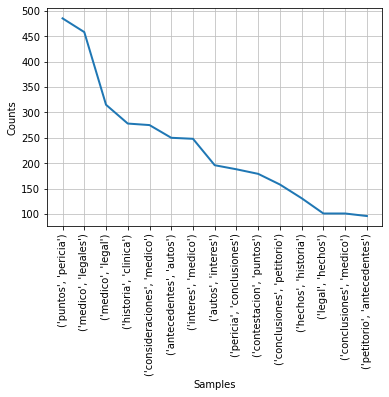

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [42]:
bgsMayusculaFdist.plot(15) #Ver las 15 colocaciones más frecuentes

### Trigrama

In [43]:
# METODO 1 - TRIGRAMAS DE TITULOS EN MAYUSCULAS

#trigrama de títulos con mayúsculas.
trigramaMay1=(list(nltk.ngrams(titulosMayusculasStop,3)))
trigramaMay1

[('proemio', 'antecedentes', 'interes'),
 ('antecedentes', 'interes', 'medico'),
 ('interes', 'medico', 'legal'),
 ('medico', 'legal', 'examen'),
 ('legal', 'examen', 'fisico'),
 ('examen', 'fisico', 'actor'),
 ('fisico', 'actor', 'consideraciones'),
 ('actor', 'consideraciones', 'medico'),
 ('consideraciones', 'medico', 'legales'),
 ('medico', 'legales', 'conclusiones'),
 ('legales', 'conclusiones', 'incapacidad'),
 ('conclusiones', 'incapacidad', 'contestacion'),
 ('incapacidad', 'contestacion', 'puntos'),
 ('contestacion', 'puntos', 'pericia'),
 ('puntos', 'pericia', 'petitorio'),
 ('pericia', 'petitorio', 'preambulo'),
 ('petitorio', 'preambulo', 'antecedentes'),
 ('preambulo', 'antecedentes', 'interes'),
 ('antecedentes', 'interes', 'medico'),
 ('interes', 'medico', 'presente'),
 ('medico', 'presente', 'autos'),
 ('presente', 'autos', 'examen'),
 ('autos', 'examen', 'perito'),
 ('examen', 'perito', 'oficio'),
 ('perito', 'oficio', 'consideraciones'),
 ('oficio', 'consideraciones',

In [44]:
# METODO 2 - TRIGRAMAS DE TITULOS EN MAYUSCULAS ---> RECOMENDADO

# Creacion de trigramas de titulos en mayusculas
f = open('titTokenEnMayusculas.csv')
raw = f.read()

token = nltk.word_tokenize(raw)

trigsMayuscula = nltk.trigrams(token)

trigsMayusculaFdist = nltk.FreqDist(trigsMayuscula)
for k,v in trigsMayusculaFdist.items():
    print(f'{k} {v}')

('tokens', 'proemio', 'antecedentes') 1
('proemio', 'antecedentes', 'interes') 13
('antecedentes', 'interes', 'medico') 46
('interes', 'medico', 'legal') 222
('medico', 'legal', 'examen') 38
('legal', 'examen', 'fisico') 5
('examen', 'fisico', 'actor') 8
('fisico', 'actor', 'consideraciones') 4
('actor', 'consideraciones', 'medico') 45
('consideraciones', 'medico', 'legales') 270
('medico', 'legales', 'conclusiones') 95
('legales', 'conclusiones', 'incapacidad') 3
('conclusiones', 'incapacidad', 'contestacion') 3
('incapacidad', 'contestacion', 'puntos') 3
('contestacion', 'puntos', 'pericia') 169
('puntos', 'pericia', 'petitorio') 55
('pericia', 'petitorio', 'preambulo') 2
('petitorio', 'preambulo', 'antecedentes') 2
('preambulo', 'antecedentes', 'interes') 2
('interes', 'medico', 'presente') 1
('medico', 'presente', 'autos') 1
('presente', 'autos', 'examen') 1
('autos', 'examen', 'perito') 1
('examen', 'perito', 'oficio') 40
('perito', 'oficio', 'consideraciones') 25
('oficio', 'cons

In [45]:
# Mostrar los trigramas de mayor frecuencia
trigsMayusculaFdist.most_common(15)

[(('consideraciones', 'medico', 'legales'), 270),
 (('interes', 'medico', 'legal'), 222),
 (('antecedentes', 'autos', 'interes'), 186),
 (('puntos', 'pericia', 'conclusiones'), 180),
 (('autos', 'interes', 'medico'), 177),
 (('contestacion', 'puntos', 'pericia'), 169),
 (('hechos', 'historia', 'clinica'), 131),
 (('pericia', 'conclusiones', 'petitorio'), 118),
 (('medico', 'legal', 'hechos'), 101),
 (('legal', 'hechos', 'historia'), 100),
 (('conclusiones', 'medico', 'legales'), 100),
 (('medico', 'legales', 'conclusiones'), 95),
 (('historia', 'clinica', 'actor'), 91),
 (('historia', 'clinica', 'contestacion'), 90),
 (('clinica', 'contestacion', 'puntos'), 90)]

In [46]:
# Creacion de dataframe de trigramas de titulos en mayusculas
import pandas as pd
trigsFrec=[]
for k,v in trigsMayusculaFdist.items():
    trigsFrec.append((k,v))

dfTrigsMayusculas = pd.DataFrame(trigsFrec,columns=['trigrama','frecuencia'])
dfTrigsMayusculas

,trigrama,frecuencia
0,"(tokens, proemio, antecedentes)",1
1,"(proemio, antecedentes, interes)",13
2,"(antecedentes, interes, medico)",46
3,"(interes, medico, legal)",222
4,"(medico, legal, examen)",38
...,...,...
4777,"(incapacidad, petitorio, nestor)",1
4778,"(petitorio, nestor, antecedentes)",1
4779,"(nestor, antecedentes, autos)",1
4780,"(petitorio, clgsa, historia)",1


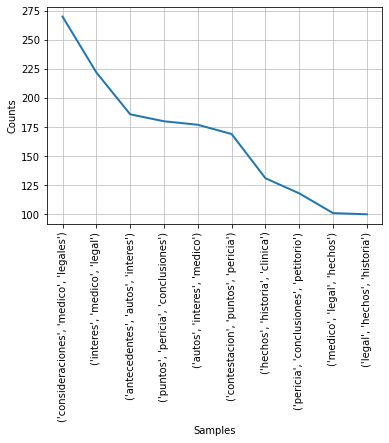

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [47]:
trigsMayusculaFdist.plot(10)

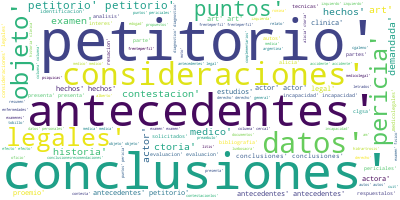

In [48]:
# Import the wordcloud library
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(dfBgsMayusculas['bigrama'].apply(str)))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [49]:
pprint(bgsMayusculas)

<generator object bigrams at 0x0000020F367FF350>
